# BAIT 509 Final Project: Predict Wine Rating from Its Description and Features

Group 24: Abhishek Kumar, Agnes Peng, Robert Zhao

## 1. Background & Motivation

A liqour chain CEO has decided to improve overall quality of the wine they are sourcing so as to increase customer satisfactory to boost sales. To reach this goal, the chain wants to understand the factors associated with the wine, as well as how wine reviews are associated with wine bottles. The chain is particularly interested in those wine associated with excellent and terrible reviews so that they could pick particular ones with high rating to market and avoid sourcing from the unfavourable wine. They have collected a 150,000-row wine dataset ([Kaggle: Wine Review](https://www.kaggle.com/zynicide/wine-reviews)) including information on wine origin, title, variety, designation, points(rating), price, tasters' personal information. 


### Business and Statistical Questions
**Business Question**: How to pick out favourable wine based on its description and features so that the wine chain could market upon? 

**Statistical Question**: What would be an appropriate machine learning model with relatively good performance in predicting wine rating from the existing wine dataset? What are the labels and target for our machine learning model? 

In addition, if an explanatory model could be developed, to what degree the model could be trusted?


- Candidate Models: Dummy Classifier, Logistic Regression, Naive Bayes
- Possible Labels, or `X`: `country`,`description`, `designation`,`price`, `province`,`region_1`,`region_2`, `variety`,`winery` 
- Target, or `y`: `points`

**Limiataion**:  The model might not capture the full sensitiveness of the taster/customer mood, as we do not have the data about the age of wines, which is an important parameter in the wine industry. The taster/customer might have given the reviews to aged wined for the same winery and region but since we do not have the data we might not be able to differentiate between the aged and latest wines of similar winery while developing the model.

In [1]:
# Import libraries
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import altair as alt
alt.data_transformers.disable_max_rows()

pd.set_option("display.max_colwidth", 200)
import seaborn as sns
from pandas_profiling import ProfileReport
from autoviz.AutoViz_Class import AutoViz_Class
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import make_column_transformer
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import lognorm, loguniform, randint
from sklearn.metrics import confusion_matrix
from IPython.display import display_html 

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import make_scorer

Imported AutoViz_Class version: 0.0.81. Call using:
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
Note: verbose=0 or 1 generates charts and displays them in your local Jupyter notebook.
      verbose=2 saves plots in your local machine under AutoViz_Plots directory and does not display charts.


In [2]:
%matplotlib inline

#  2. Exploratoary Data Analysis (EDA).

### 2.0.1 Loading Data

In [3]:
### Loading the the wine data - Please have the data file in the directory. 
wine_df = pd.read_csv('winemag-data_first150k.csv')
del wine_df['Unnamed: 0']
wine_df

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,"This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tanni...",Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are softened and sweetened by a slathering of oaky chocolate and vanilla. This is full, layered, intense and cushioned on the palate, with rich flavors of...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,"Mac Watson honors the memory of a wine once made by his mother in this tremendously delicious, balanced and complex botrytised white. Dark gold in color, it layers toasted hazelnut, pear compote a...",Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, and incorporates fruit from Ponzi's Aurora, Abetina and Madrona vineyards, among others. Aromatic, dense and toasty, it deftly blends aromas and flavors...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named after the highest point in the vineyard at 1200 feet. It has structure, density and considerable acidity that is still calming down. With 18 months in wo...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude
...,...,...,...,...,...,...,...,...,...,...
150925,Italy,"Many people feel Fiano represents southern Italy’s most promising white grape, and after tasting this rendition, who can argue? The flavor package is pineapple, citrus and wet stones. The structur...",NaN,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Feudi di San Gregorio
150926,France,"Offers an intriguing nose with ginger, lime and floral elements. The mouthfeel is ephemeral—almost too light—but there’s a good case to be made for this style when bubbles are involved. Green appl...",Cuvée Prestige,91,27.0,Champagne,Champagne,NaN,Champagne Blend,H.Germain
150927,Italy,"This classic example comes from a cru vineyard called Terre di Dora, which is named after the Mastroberardinos’ mother. They should all be proud of this one. Wet stones, apples, peaches and pears ...",Terre di Dora,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Terredora
150928,France,"A perfect salmon shade, with scents of peaches, cherries and toast. It hits the palate with big, ripe, fresh fruit: crisp apples, peaches, cherries and citrus. Concentrated and full, with a tart, ...",Grand Brut Rosé,90,52.0,Champagne,Champagne,NaN,Champagne Blend,Gosset


**Country:** Origin country of wine.<br>
**Description:** Customer comments/opinion about wine .<br>
**Designation:** Information about vineyard.<br>
**Points:**  Rating in form of points from winetaseters  <br>
**Province:** Province of origination.<br>
**Region_1:** Region of origination .<br>
**Region_2:** Region 2 , extra details about origination.<br>
**Variety:** Grape variety .<br>
**Winery:** Producer of Particular wine.<br>

*reference: [Wine Rating](https://www.kaggle.com/zynicide/wine-reviews/data?select=winemag-data_first150k.csv)  May 17th, 2021*

### 2.0.2 Splitting of dataset 
split the dataset into the training set and the test set in a 80/20 split.

In [4]:
# Splitiing the Data
train_df, test_df = train_test_split(wine_df, test_size=.2, random_state=77)

### 2.1 Info of the training set

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120744 entries, 22523 to 74335
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      120739 non-null  object 
 1   description  120744 non-null  object 
 2   designation  84174 non-null   object 
 3   points       120744 non-null  int64  
 4   price        109755 non-null  float64
 5   province     120739 non-null  object 
 6   region_1     100742 non-null  object 
 7   region_2     48611 non-null   object 
 8   variety      120744 non-null  object 
 9   winery       120744 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 10.1+ MB


- We can see from the plot that we have missing values in some columns, **particularly in `region_2`. So we would drop this column as it has more than 50% of the missing values.**
- For remaining columns, We would impute the missing values using the "constant" startegy in `SimpleImputer`.

### 2.2  Variation 

To better understand the dataset we decided to understand the variation in pricing and points. Also, we would be looking at how the various factors like province, region and winery affects the price and points in our data. 

In [6]:
# Describing the Train data
train_df.describe()

,points,price
count,120744.000000,109755.000000
mean,87.889253,33.178060
std,3.220817,37.088745
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,24.000000
75%,90.000000,40.000000
max,100.000000,2300.000000


In [7]:
# Group by different categories and see the standard deviation to see how values are impacted

x = train_df.groupby(['winery']).std().nlargest(10, 'points')
x1= train_df.groupby(['variety']).std().nlargest(10, 'points')
x2= train_df.groupby(['province']).std().nlargest(10, 'points')
df1_styler = x.style.set_table_attributes("style='display:inline'").set_caption('Deviation Based on winery')
df2_styler = x1.style.set_table_attributes("style='display:inline'").set_caption('Deviaton Based on variety')
df2_t_styler = x2.style.set_table_attributes("style='display:inline'").set_caption('Deviation Based on province')
display_html(df1_styler._repr_html_()+df2_styler._repr_html_() +df2_t_styler._repr_html_(), raw= True)

,points,price
winery,,
Ancien,7.071068,9.192388
Sirius,7.071068,nan
Talmage,7.071068,5.656854
Château Mazeyres,6.363961,nan
Illumination,6.363961,0.000000
Priest Ranch,6.363961,16.970563
Temple Bruer,6.363961,0.707107
Vinifera,6.363961,1.414214
Whitcraft,6.363961,nan


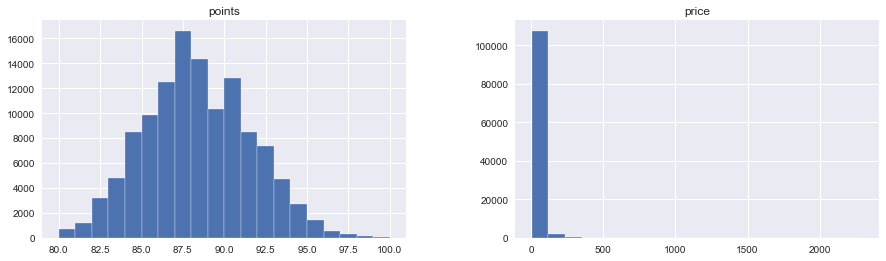

In [8]:
# Visualizng distribution of Points and price 
train_df.hist(figsize=(15, 4), bins=20, xlabelsize=10, ylabelsize= 10);


- Average points for wines is around the 87.89, which shows that average rating has been good in most of tasters' opinions. With not much of variation can be seen from the standard deviation.
- Average price of the wine is around 33 but the there is huge deviation in the pricing.
- From the tables above, we can see that the price of wine is very unevenly distributed compared to the points.
- There is very high price deviation for the wines from similar winery, region, and province while the points are not so varying compared to the price.
-  Wines produced at same **winery** do not have much of the variation in the points and price, suggesting the winery might be an imporatnt consideration for the cusomter. 
- Province has major fluctuations in price. For example, Bourdeax has a devaition of more than 104,  which could be due to different types of wines are produced or the quality of the wine is considered superior as compared to the other region.

### 2.3 Correlation

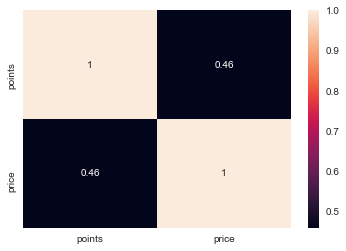

In [9]:
# correlation matrix
sns.heatmap(wine_df.corr(), annot=True)

- Price and points have some degrees of correlation.

### 2.4 Summary of observations from EDA:
- The wine data has 10 columns reperesenting the various parameters related to the wine. 
- There are only 1 numerical feature and 8 categorical features. We cannot plot the features as we have only one numerical feature.
- The categorical feature `region_2` have more than 50% missing values. So, we will drop the column while building our column. 
- The categorical feature `desgination` have 30% missing values. So, we will impute the frequent values to fill up the colmun in the ratio of frequency. 
- There is some correlations (0.46) between the price and and our target - points.
- The target column has a range from 80 to 100.

## 3. Method & Results

Noting that our target column is composed of integer values from 80 to 100, we thought linear regression would not be the best solution in this case since the liquor store owner simply would like a general idea of the quality of the wine. Instead, linear regression would return too much unnecessary granuality. Therefore, we proceeded with developing a logistic regression with simplified level of points described as followed.

### 3.1 Data Preprocessing

We first preprocessed the target column by classifying its values into 5 levels. Each level is 4 points in length. Level 1 being the lowest while 5 being the highest. The classifying results were stored in a new column called `rating`.

In [10]:
def rating(x):
    if x >= 80 and x < 84:
        return 1
    elif x >= 84 and x < 88:
        return 2
    elif x >= 88 and x < 92:
        return 3
    elif x >= 92 and x < 96:
        return 4
    else:
        return 5

In [11]:
train_df['rating'] = train_df['points'].apply(lambda x: rating(x))
test_df['rating'] = test_df['points'].apply(lambda x: rating(x))

Define the labels and target. Drop the `region_2` column since it contains 50% missing values.

In [12]:
X_train = train_df.drop(columns=['rating','points','region_2'])
y_train = train_df['rating']
X_test = test_df.drop(columns=['rating','points','region_2'])
y_test = test_df['rating']

### 3.2 Baseline Model: Dummy Classifier

Build a baseline model with a dummy classifier which classified rating by respecting the training set’s class distribution. It was used to set as a baseline to compare with other models we developed later in the project.

In [13]:
dummy_cla = DummyClassifier(strategy='stratified')
dummy_scores_df = pd.DataFrame(cross_validate(dummy_cla, X_train, y_train, cv = 5,
                                              return_train_score=True, scoring=['accuracy']))
dummy_scores_df

,fit_time,score_time,test_accuracy,train_accuracy
0,0.018015,0.004983,0.326804,0.327481
1,0.020011,0.002989,0.325769,0.324965
2,0.018008,0.003997,0.326308,0.322936
3,0.019010,0.004986,0.323036,0.324396
4,0.019982,0.004018,0.325410,0.324196


In [14]:
dummy_scores_df.mean()

fit_time          0.019005
score_time        0.004195
test_accuracy     0.325465
train_accuracy    0.324795
dtype: float64

As described in the table, the dummy classifier achieved an accuracy around 32% for the training set and the test set.

### 3.3 Explanatory Model: Logistic Regression

Since we are dealing with categorical data as target, we fit an explanatory model with `LogisticRegression`.

#### 3.3.1 Full Model: using all the features as explanatory variables

This full model is useful when the business has compatible computational power and wish to utilize all the information in the dataset except `region_2` which has too much missing values.

In [15]:
# seprating the numerical, categorical, and text features
numeric_features = [ "price" ]
categorical_features = ["country", "designation", "province","region_1", "winery", "variety"]
text_feature = "description"

Under this model, numeric features would go through a preprocessor with `SimpleImputer` and `MinMaxScaler`. Categorical features would go through a preprocessor with `SimpleImputer` and `OneHotEncoder`. Text feature would go through the `CountVectorizer`.

In [16]:
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'),
                            MinMaxScaler())
categoric_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="missing"),
                            OneHotEncoder(dtype=int, handle_unknown="ignore"))
text_pipe = make_pipeline(CountVectorizer())

preprocessor = make_column_transformer((numeric_pipe, numeric_features),(text_pipe, text_feature),
                                       (categoric_pipe, categorical_features))

main_pipe = make_pipeline(preprocessor,
    (LogisticRegression(max_iter=1000, class_weight="balanced")))

**Hyperparameter tuning**

Randomized search for the best model hyperparameter in most efficient way. We chose number of iterations to 10 and 5-fold cross validation for best trade off between runtime and quality.

In [17]:
param_grid = {
    "columntransformer__pipeline-2__countvectorizer__max_features": randint(10, 10000),
    "logisticregression__C": loguniform(0.01, 100), 
}

random_search_1 = RandomizedSearchCV(main_pipe, param_grid, cv=5, verbose=2, return_train_score=True, n_iter=10, n_jobs=-1, scoring='accuracy')

In [18]:
random_search_1.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 18.2min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('minmaxscaler',
                                                                                                MinMaxScaler())]),
                                                                               ['price']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('countvectorizer',
                                             

In [19]:
best_estimator = random_search_1.best_estimator_
best_estimator

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['price']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('countvectorizer',
                                                                   CountVectorizer(max_features=6700))]),
                                                  'description'),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
           

We found the best hyperparameters to be `max_features = 6700` and `C = 93.14618995467448` .

**Model accuracy**

In [20]:
random_search_1.score(X_test,y_test)

0.8363148479427549

The full model we created achieved an accuracy more than 80% for the test set.

**Confusion Matrix**

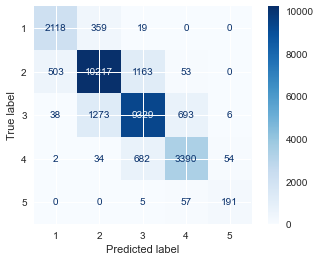

In [21]:
plot_confusion_matrix(random_search_1, X_test, y_test, cmap='Blues', values_format="d");

The confusion matrix tells us the the accuracy is relatively high and we have a concentration of data at rating = 2. For example, For all (503 + 10217 + 1163 + 53) data points with true label of rating 2, we predicted 10217 correct, with 86% accuracy for one-vs-all multi-class comparison.

#### 3.3.2 Alternative Model: using only description as the explanatory variable

This model is helpful when the wine only has description available or the business prefer to ease the computational power.

In [22]:
X_train2 = train_df['description']
y_train2 = train_df['rating']
X_test2 = test_df['description']
y_test2 = test_df['rating']

#### Hyperparameter tuning
Perform the similar hyperparameter tuning procedure as with the full model.

Since we were dealing with text data as feature and categorical data as target, we fit an explanatory model with `CountVectorizer` and `LogisticRegression`.

In [23]:
param_grid = {
    "countvectorizer__max_features": randint(10, 10000),
    "logisticregression__C": loguniform(0.01, 100), 
}

pipe_1 = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=1000, class_weight="balanced"))

random_search_2 = RandomizedSearchCV(pipe_1, param_grid, cv=5, verbose=2, return_train_score=True, n_iter=10, n_jobs=-1, scoring='accuracy')

In [24]:
random_search_2.fit(X_train2, y_train2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.4min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer()),
                                             ('logisticregression',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=1000))]),
                   n_jobs=-1,
                   param_distributions={'countvectorizer__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F8F240DE50>,
                                        'logisticregression__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F8F2711430>},
                   return_train_score=True, scoring='accuracy', verbose=2)

In [25]:
random_search_2_df = pd.DataFrame(random_search_2.cv_results_)
random_search_2_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__max_features,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,93.569996,0.632102,0.962802,0.035091,7784,3.15058,"{'countvectorizer__max_features': 7784, 'logisticregression__C': 3.150579476288992}",0.692410,0.690795,0.690795,...,0.692614,0.001704,1,0.792184,0.793457,0.790745,0.790320,0.790095,0.791360,0.001276
1,38.049399,1.292351,1.046805,0.034097,9521,0.0422635,"{'countvectorizer__max_features': 9521, 'logisticregression__C': 0.04226347080856168}",0.651124,0.646693,0.645865,...,0.648753,0.002111,8,0.692179,0.693276,0.694984,0.692003,0.693579,0.693204,0.001078
2,44.009803,0.812722,0.999602,0.048431,3409,0.0926224,"{'countvectorizer__max_features': 3409, 'logisticregression__C': 0.09262235087412618}",0.644871,0.645824,0.643091,...,0.645548,0.001461,9,0.686847,0.688690,0.689580,0.685884,0.687523,0.687705,0.001309
3,40.864201,0.501639,0.978196,0.048314,7605,0.054974,"{'countvectorizer__max_features': 7605, 'logisticregression__C': 0.054974014877298014}",0.652905,0.649012,0.649468,...,0.651685,0.002018,6,0.696837,0.698411,0.700471,0.697500,0.698932,0.698430,0.001251
4,44.665600,1.060716,0.999802,0.056451,9740,0.0671783,"{'countvectorizer__max_features': 9740, 'logisticregression__C': 0.06717825549911215}",0.659448,0.654437,0.655017,...,0.657672,0.002563,5,0.708525,0.710078,0.711528,0.708826,0.710268,0.709845,0.001081
5,86.656200,0.435712,1.011202,0.034325,3767,25.4777,"{'countvectorizer__max_features': 3767, 'logisticregression__C': 25.477720225691616}",0.668475,0.665369,0.664582,...,0.666807,0.001938,4,0.733848,0.735877,0.735028,0.732398,0.732836,0.733997,0.001306
6,41.118200,1.183531,1.046606,0.042561,9501,0.0483166,"{'countvectorizer__max_features': 9501, 'logisticregression__C': 0.04831659498041801}",0.652822,0.648805,0.648723,...,0.651237,0.002023,7,0.697044,0.697645,0.699612,0.696527,0.698321,0.697830,0.001074
7,41.796791,1.277628,1.021402,0.098619,2860,0.0763989,"{'countvectorizer__max_features': 2860, 'logisticregression__C': 0.07639891536776508}",0.643256,0.641724,0.635803,...,0.640554,0.002518,10,0.676650,0.677696,0.677778,0.676464,0.676850,0.677087,0.000545
8,90.042002,0.531411,1.020801,0.049317,4834,1.11601,"{'countvectorizer__max_features': 4834, 'logisticregression__C': 1.1160118499765985}",0.672160,0.669427,0.669137,...,0.670907,0.002734,3,0.741664,0.743144,0.741664,0.742140,0.740745,0.741871,0.000781
9,84.335810,2.573779,0.875196,0.087725,6169,30.5258,"{'countvectorizer__max_features': 6169, 'logisticregression__C': 30.525846342445075}",0.686115,0.684790,0.683714,...,0.685392,0.001060,2,0.780879,0.782194,0.779440,0.778322,0.779504,0.780068,0.001337


We can observe that the worst test accuracy at 0.64 is doubling the test accuracy at 0.32 for the baseline dummy classifier.

In [26]:
best_estimator2 = random_search_2.best_estimator_
best_estimator2

Pipeline(steps=[('countvectorizer', CountVectorizer(max_features=7784)),
                ('logisticregression',
                 LogisticRegression(C=3.150579476288992,
                                    class_weight='balanced', max_iter=1000))])

We found the best hyperparameter to be `max_features = 7784` and `C = 3.150579476288992` .

#### Most informative words

In [27]:
coef_df = pd.DataFrame({'words': best_estimator2[ "countvectorizer"].get_feature_names(),
              'coefficient': best_estimator2["logisticregression"].coef_[0]})

coef_df

,words,coefficient
0,000,0.761119
1,01,-0.595401
2,02,1.207407
3,03,-1.126602
4,04,-0.521672
...,...,...
7779,zone,0.777435
7780,zonin,-0.727610
7781,zucchini,-0.678063
7782,zweigelt,1.189346


In [28]:
# Most informative postive words 
coef_df.sort_values(by=['coefficient'], ascending=False).head(10)

,words,coefficient
3383,hudson,4.426695
3635,joining,4.136701
2986,georgian,3.725254
606,bardolino,3.658832
980,broth,3.180002
4589,norton,3.162659
5132,pollen,3.055302
6976,thinly,2.995131
4775,overrides,2.987738
5211,precocious,2.981247


In [29]:
# Most informative negative words
coef_df.sort_values(by=['coefficient'], ascending=True).head(10)

,words,coefficient
5896,sample,-3.597817
6366,sophisticated,-3.496340
7463,vintner,-3.431041
1600,consider,-3.383827
3625,jerky,-3.332526
1929,deliciously,-3.297281
2803,format,-3.278182
6654,stylish,-3.210938
6688,succulent,-3.157266
4637,oakville,-3.149829


#### Model accuracy

In [30]:
random_search_2.score(X_test2,y_test2)

0.7021466905187835

The explanatory model with only description as label achieved an accuracy of 70% on the test set.

#### Confusion matrix

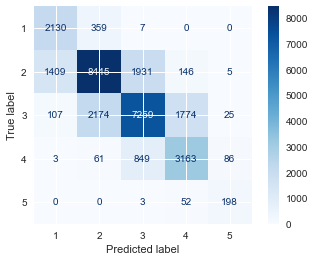

In [31]:
plot_confusion_matrix(random_search_2, X_test2, y_test2, cmap='Blues');

The confusion matrix tells us the the accuracy is relatively high and we have a concentration of data at rating = 2. For example, For all (1409 + 8115 + 1931 + 146 + 5) data points with true label of rating 2, we predicted 8115 correct, with 70% accuracy for one-vs-all multi-class comparison.

### 3.4 Model Comparison and Selection

We want to know if Naive Bayes classification would produce a better result, as Logistic Regression and Naive Bayes are two algorithms that generalizes well on high dimensional data yet efficient. Problem with Naive Bayes is it doesn't have the interpretable power that Logic Regression has.

In [32]:
def get_randomcv(classifier, param_grid):
    pipe = make_pipeline(preprocessor, classifier)
    return RandomizedSearchCV(pipe, param_grid, cv=5, verbose=2, return_train_score=True, n_iter=1, n_jobs=-1, scoring='accuracy')

In [33]:
def get_result(result):
    print(result.best_estimator_)
    print(result.score(X_test,y_test))
    plot_confusion_matrix(result, X_test, y_test, cmap='Blues')
    plt.show();

#### 3.4.1 Predictive Model: Naive Bayes

In [34]:
nb = get_randomcv(MultinomialNB(), {
    "columntransformer__pipeline-2__countvectorizer__max_features": randint(10, 10000),
    "multinomialnb__alpha": randint(0, 10),
})

nb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.6s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('minmaxscaler',
                                                                                                MinMaxScaler())]),
                                                                               ['price']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('countvectorizer',
                                             

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['price']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('countvectorizer',
                                                                   CountVectorizer(max_features=6400))]),
                                                  'description'),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
           

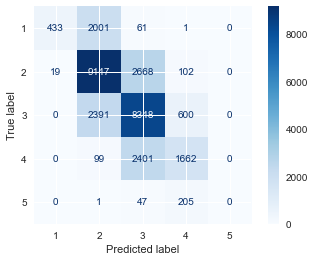

In [35]:
get_result(nb)

In [36]:
confusion_matrix(y_test, nb.predict(X_test))

array([[ 433, 2001,   61,    1,    0],
       [  19, 9147, 2668,  102,    0],
       [   0, 2391, 8348,  600,    0],
       [   0,   99, 2401, 1662,    0],
       [   0,    1,   47,  205,    0]], dtype=int64)

The accuracy for Naive Bayes is only at 65%. For the same exmaple for data points with label rating = 2, among all 11936 observations, we got 9147 labels right in the one-vs-all paradigm, resulting in an accuracy of 77%, much lower than the Logistic Regression model. 

As a result, we don't have to make the trade off between model interpretability and its performance. In fact, the Naive Bayes has worse performance than the Logistic Regression model. Thus, the Logistic Regression allows us to identify the rationale behind the model's decision yet achieved a higher score than the Naive Bayes model.

## 4. Results

As the result of our analysis, we have provided the `coefficients.csv` file that can be opened with Microsoft Excel. This file contains the **8858** most common words from reviews and each word has a coefficient associated. The coefficients, ranging from `-1` to `+1`, represent the sentimental intensity the words convey. With `-1` means the most negative review and `+1` the most positive review. In our anaysis above, we have identified the top 10 most positive words and the 10 most negative words, exampled by `Hudson` and `Intrude`.

We have also developed machine learning models that can predict the rating of that bottle from wine features or simply wine description text. Logistic Regression models produce the highest accuracy scores among our candidate models. We attempted to use two approaches to form the features for Logistic Regression model: one with nearly all the columns in the dataset, and the other with wine description only. 

The former has an accuracy of **83.6%**, means that our results is trustworthy as it is right more than 3/4 of the times. The predicted ratings from the model could be used to modify the current purchasing lists of the wine chain, sourcing more popular wines but not low-rating wines that are not attractive customers. Moreover, they are also good references for prioritizing wine listings on the company's e-commerce website and picking particular wines for future marketing campaign.

The later which predicts directly from wine description still achieved an accuracy of **70%** considering it has significantly less data feed into the model pipeline. This model could be further enhanced by adopting to `Stop Words`, means filtering out common words in English that doesn't provide much value such as `I`, `Me`, `The` etc. We are expecting to see an increase in accuracy if we use this technology. We can also develop a graphical user interface for the liquor store business owner, which anyone can type the reviews in a textbox and click a button to see the predicted rating.

## Appendix

### Dataset Identification

To complete this project, we obtained a dataset called Wine Reviews from Kaggle. 


**Wine Reviews Dataset**
- URL: https://www.kaggle.com/zynicide/wine-reviews
- Publication Date: 2017-11-27
- Publisher: zackthoutt
- Language: English
- Data Version: 4.0
- Access Date: 2021-05-19

### Pandas Profiling

In [37]:
profile = ProfileReport(wine_df)
profile

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Auto viz profiling

In [38]:
AV = AutoViz_Class()

#dft = AV.AutoViz(filename = “ ”, sep= ‘,’ , depVar=’rating’, dfte= wine_df, header=0, verbose=2, lowess=False, chart_format=”svg”)

df = AV.AutoViz(filename="",sep=',', depVar='Adj Close', dfte=wine_df, header=0, verbose=1, 
                 lowess=False, chart_format='svg', max_rows_analyzed=150000, max_cols_analyzed=20)

Shape of your Data Set: (150930, 10)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  1
    Number of Integer-Categorical Columns =  1
    Number of String-Categorical Columns =  1
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  6
    Number of NLP String Columns =  1
    Number of Date Time Columns =  0
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    10 Predictors classified...
        This does not include the Target column(s)
        7 variables removed since they were ID or low-information variables
    List of variables removed: ['description', 'country', 'designation', 'province', 'region_1', 'variety', 'winery']
Since Number of Rows in data 150930 exceeds maximum, randomly sampling 150000 rows for EDA...
Could not find given target var i

### Export the most informative words in description as a CSV file

In [39]:
pipe_2 = make_pipeline(CountVectorizer(max_features=8858), LogisticRegression(max_iter=1000, class_weight="balanced", C = 42.52533247431093))
pipe_2.fit(X_train2, y_train2)

Pipeline(steps=[('countvectorizer', CountVectorizer(max_features=8858)),
                ('logisticregression',
                 LogisticRegression(C=42.52533247431093,
                                    class_weight='balanced', max_iter=1000))])

In [40]:
coef_df = pd.DataFrame({'words': pipe_2[ "countvectorizer"].get_feature_names(),
              'coefficient': pipe_2["logisticregression"].coef_[0]})

In [41]:
coef_df.to_csv('coefficients.csv')